<a href="https://colab.research.google.com/github/zhestyatsky/bachelor-degree-research/blob/main/src/cosine_similarity_relu_with_threshold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%writefile requirements.txt
pytorch-lightning
scikit-learn
transformers
sentencepiece

Writing requirements.txt


In [ ]:
!pip install --upgrade -r requirements.txt

     |████████████████████████████████| 696kB 7.7MB/s 
     |████████████████████████████████| 22.2MB 1.6MB/s 
     |████████████████████████████████| 1.8MB 48.5MB/s 
     |████████████████████████████████| 1.2MB 48.4MB/s 
     |████████████████████████████████| 102kB 13.7MB/s 
     |████████████████████████████████| 276kB 54.9MB/s 
     |████████████████████████████████| 829kB 52.9MB/s 
     |████████████████████████████████| 890kB 18.3MB/s 
     |████████████████████████████████| 2.9MB 50.2MB/s 
     |████████████████████████████████| 1.3MB 47.7MB/s 
     |████████████████████████████████| 143kB 58.7MB/s 
     |████████████████████████████████| 296kB 49.5MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=9d1dd3514e22846c0058d1495c78a5293b5ec5aa9d5530eb1e0eae21f06d51c7
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for future: filename=future-0.18.2-cp36-none-

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import torch
import random
import numpy as np


def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [ ]:
!mkdir data && git clone https://github.com/SapienzaNLP/mcl-wic.git data && cd data && unzip 'SemEval-2021_MCL-WiC_all-datasets.zip' && rm *.zip && ls

Cloning into 'data'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 162 (delta 27), reused 0 (delta 0), pack-reused 96
Receiving objects: 100% (162/162), 7.35 MiB | 29.06 MiB/s, done.
Resolving deltas: 100% (54/54), done.
Archive:  SemEval-2021_MCL-WiC_all-datasets.zip
   creating: MCL-WiC/
   creating: MCL-WiC/training/
  inflating: MCL-WiC/training/training.en-en.gold  
  inflating: MCL-WiC/training/training.en-en.data  
   creating: MCL-WiC/test/
   creating: MCL-WiC/test/multilingual/
  inflating: MCL-WiC/test/multilingual/test.zh-zh.data  
  inflating: MCL-WiC/test/multilingual/test.ru-ru.data  
  inflating: MCL-WiC/test/multilingual/test.fr-fr.data  
  inflating: MCL-WiC/test/multilingual/test.en-en.data  
  inflating: MCL-WiC/test/multilingual/test.ar-ar.data  
   creating: MCL-WiC/test/crosslingual/
  inflating: MCL-WiC/test/crosslingual/test.en-ru.data  
  inflating: MCL-WiC/

In [ ]:
!cd data && mkdir SuperGLUE-WiC && wget https://pilehvar.github.io/wic/package/WiC_dataset.zip && unzip 'WiC_dataset.zip' -d SuperGLUE-WiC && rm *.zip && ls

--2021-01-30 01:01:07--  https://pilehvar.github.io/wic/package/WiC_dataset.zip
Resolving pilehvar.github.io (pilehvar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to pilehvar.github.io (pilehvar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 275513 (269K) [application/zip]
Saving to: ‘WiC_dataset.zip’

WiC_dataset.zip     100%[===================>] 269.06K  --.-KB/s    in 0.02s   

2021-01-30 01:01:07 (12.4 MB/s) - ‘WiC_dataset.zip’ saved [275513/275513]

Archive:  WiC_dataset.zip
   creating: SuperGLUE-WiC/dev/
  inflating: SuperGLUE-WiC/dev/dev.data.txt  
  inflating: SuperGLUE-WiC/dev/dev.gold.txt  
   creating: SuperGLUE-WiC/test/
  inflating: SuperGLUE-WiC/test/test.data.txt  
   creating: SuperGLUE-WiC/train/
  inflating: SuperGLUE-WiC/train/train.data.txt  
  inflating: SuperGLUE-WiC/train/train.gold.txt  
  inflating: SuperGLUE-WiC/README.txt  
MCL-WiC  README.md  SuperGLUE-WiC


In [ ]:
import json
import pandas as pd

def read_train_data(path, read_tags=False):
    with open(path) as f:
        df = pd.DataFrame(json.load(f))
    
    if read_tags:
        tags_path = path[:path.find('.data')] + '.gold'
        with open(tags_path) as f:
            df = df.merge(pd.DataFrame(json.load(f)))
        df['tag'] = df['tag'].replace({'T': 1, 'F': 0})

    df['lemma'] = df['lemma'].apply(lambda lemma: lemma.lower())
    return df


df_train_wic = read_train_data('data/MCL-WiC/training/training.en-en.data', True)
df_dev_wic = read_train_data('data/MCL-WiC/dev/multilingual/dev.en-en.data', True)
df_test_wic = read_train_data('data/MCL-WiC/test/multilingual/test.en-en.data')
print(df_train_wic.shape)
print(df_dev_wic.shape)
print(df_test_wic.shape)
print(df_train_wic.head())
print(df_dev_wic.head())
print(df_test_wic.head())

(8000, 10)
(1000, 10)
(1000, 9)
                 id   lemma   pos  ... start2 end2 tag
0  training.en-en.0    play  NOUN  ...     10   14   0
1  training.en-en.1    play  NOUN  ...    112  116   0
2  training.en-en.2  esteem  NOUN  ...    106  112   1
3  training.en-en.3  esteem  NOUN  ...     20   26   1
4  training.en-en.4  holder  NOUN  ...     27   33   1

[5 rows x 10 columns]
            id         lemma   pos  ... start2 end2 tag
0  dev.en-en.0      superior  NOUN  ...     41   50   0
1  dev.en-en.1      superior  NOUN  ...     44   53   1
2  dev.en-en.2  acquaintance  NOUN  ...     41   54   0
3  dev.en-en.3  acquaintance  NOUN  ...     74   86   0
4  dev.en-en.4       baggage  NOUN  ...      6   13   1

[5 rows x 10 columns]
             id   lemma   pos  ... end1 start2 end2
0  test.en-en.0  gently   ADV  ...  122     59   65
1  test.en-en.1  gently   ADV  ...  122     72   78
2  test.en-en.2    next   ADJ  ...   87     85   89
3  test.en-en.3    next   ADJ  ...   87     84  

In [ ]:
def find_nth_word_start_end_indices_in_sentence(sentence, n):
    words = sentence.split(' ')
    start_idx = n
    for word in words[:n]:
        start_idx += len(word)
    return start_idx, start_idx + len(words[n])


sentence_to_test = 'I code python and it is very boring'
assert find_nth_word_start_end_indices_in_sentence(sentence_to_test, 0) == (0, 1)
assert find_nth_word_start_end_indices_in_sentence(sentence_to_test, 1) == (2, 6)
assert find_nth_word_start_end_indices_in_sentence(sentence_to_test, 2) == (7, 13)
assert find_nth_word_start_end_indices_in_sentence(sentence_to_test, 7) == (sentence_to_test.find('boring'), sentence_to_test.find('boring') + 6)


def get_word_start_end_in_sentence(row):
    first_word_pos, second_word_pos = [int(idx) for idx in row['word_indices'].split('-')]
    start1, end1 = find_nth_word_start_end_indices_in_sentence(row['sentence1'], first_word_pos)
    start2, end2 = find_nth_word_start_end_indices_in_sentence(row['sentence2'], second_word_pos)
    return (start1, end1), (start2, end2)


def read_data_superglue(path, read_tags=False):
    df = pd.read_csv(path, sep='\t', names=['lemma', 'pos', 'word_indices', 'sentence1', 'sentence2'])
    if read_tags:
        tags_path = path[:path.find('.data.txt')] + '.gold.txt'
        df = df.join(pd.read_csv(tags_path, names=['tag']))
        df['tag'] = df['tag'].replace({'T': 1, 'F': 0})

    df['pos'] = df['pos'].replace({'N': 'NOUN', 'V': 'VERB'})
    
    id_string = path[path.rfind('/') + 1 : path.find('.data')]
    df['id'] = df.index
    df['id'] = df['id'].apply(lambda id: id_string + '_superglue.en-en.' + str(id))

    df['start1'] = df.apply(lambda row: get_word_start_end_in_sentence(row)[0][0], axis=1)
    df['end1'] = df.apply(lambda row: get_word_start_end_in_sentence(row)[0][1], axis=1)
    df['start2'] = df.apply(lambda row: get_word_start_end_in_sentence(row)[1][0], axis=1)
    df['end2'] = df.apply(lambda row: get_word_start_end_in_sentence(row)[1][1], axis=1)
    df = df.drop(columns='word_indices')
    
    return df

df_train_superglue = read_data_superglue('data/SuperGLUE-WiC/train/train.data.txt', True)
df_dev_superglue = read_data_superglue('data/SuperGLUE-WiC/dev/dev.data.txt', True)
df_test_superglue = read_data_superglue('data/SuperGLUE-WiC/test/test.data.txt')
print(df_train_superglue.shape)
print(df_dev_superglue.shape)
print(df_test_superglue.shape)
print(df_train_superglue.head())
print(df_dev_superglue.head())
print(df_test_superglue.head())

(5428, 10)
(638, 10)
(1400, 9)
     lemma   pos  ... start2 end2
0    carry  VERB  ...      6   13
1       go  VERB  ...     27   29
2    break  VERB  ...     15   20
3      cup  NOUN  ...     22   26
4  academy  NOUN  ...     11   18

[5 rows x 10 columns]
         lemma   pos  ... start2 end2
0        board  NOUN  ...     10   16
1    circulate  VERB  ...     21   31
2         hook  VERB  ...      3    9
3   recreation  NOUN  ...     42   52
4  domesticity  NOUN  ...     39   50

[5 rows x 10 columns]
          lemma   pos  ... start2 end2
0        defeat  NOUN  ...     17   23
1         groom  VERB  ...      7   14
2   penetration  NOUN  ...      4   15
3           hit  VERB  ...     20   23
4  deliberation  NOUN  ...      9   21

[5 rows x 9 columns]


In [ ]:
from sklearn.model_selection import train_test_split

def lemma_train_test_split(df, test_size=0.2):
    unique_lemmas = sorted(set(df['lemma'].tolist()))
    train_lemmas, test_lemmas = train_test_split(unique_lemmas, test_size=test_size, random_state=1)
    df_train = df[df['lemma'].isin(train_lemmas)]
    df_test = df[df['lemma'].isin(test_lemmas)]
    return df_train, df_test

global_df = pd.concat([df_train_wic, df_dev_wic, df_train_superglue, df_dev_superglue], ignore_index=True)
df_train, df_val = lemma_train_test_split(global_df)
print(df_train.shape)
print(df_val.shape)
df_test = df_test_wic
print(df_test.shape)

(12032, 10)
(3034, 10)
(1000, 9)


In [ ]:
train_labels = df_train["tag"].tolist()
val_labels = df_val["tag"].tolist()
#test_labels = df_test["tag"].tolist()

train_sentences = [(s1, s2) for s1, s2 in zip(df_train["sentence1"], df_train["sentence2"])]
val_sentences = [(s1, s2) for s1, s2 in zip(df_val["sentence1"], df_val["sentence2"])]
test_sentences = [(s1, s2) for s1, s2 in zip(df_test["sentence1"], df_test["sentence2"])]

train_word_ranges = [((int(s1), int(e1)), (int(s2), int(e2))) for s1, e1, s2, e2 in zip(df_train["start1"], df_train["end1"], df_train["start2"], df_train["end2"])]
val_word_ranges = [((int(s1), int(e1)), (int(s2), int(e2))) for s1, e1, s2, e2 in zip(df_val["start1"], df_val["end1"], df_val["start2"], df_val["end2"])]
test_word_ranges = [((int(s1), int(e1)), (int(s2), int(e2))) for s1, e1, s2, e2 in zip(df_test["start1"], df_test["end1"], df_test["start2"], df_test["end2"])]

print(train_sentences[0])
print(train_word_ranges[0])

('In that context of coordination and integration, Bolivia holds a key play in any process of infrastructure development.', 'A musical play on the same subject was also staged in Kathmandu for three days.')
((69, 73), (10, 14))


In [ ]:
import torch
from torch.utils.data import Dataset, RandomSampler, DataLoader
from transformers import BertTokenizerFast

INDICES_PADDING_LEN = 6
INDICES_PADDING_VALUE = 0

class BertDataset(Dataset):
    def __init__(self, sentences, word_ranges, max_tokens, labels=None):
        self.sentences = sentences
        self.word_ranges = word_ranges
        self.labels = labels
        self.tokenizer = BertTokenizerFast.from_pretrained("bert-large-cased")
        self.max_tokens = max_tokens
    
    def _tokenize(self, sentence):
        return self.tokenizer(sentence,
                              add_special_tokens=True,
                              max_length=self.max_tokens,
                              padding="max_length",
                              truncation=True,
                              return_offsets_mapping=True)
        
    def _get_input_ids_indices_for_word(self, offset_mapping, word_start, word_end):
        indices = []
        for idx, (start, end) in enumerate(offset_mapping):
            if start != end and word_start <= start and end <= word_end:
                indices.append(idx)
            elif word_start < start:
                break

        indices.extend([INDICES_PADDING_VALUE for i in range(INDICES_PADDING_LEN - len(indices))])
        return torch.tensor(indices)
    
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, index):
        first_sentence, second_sentence = self.sentences[index]
        (first_word_start, first_word_end), (second_word_start, second_word_end) = self.word_ranges[index]

        first_input = self._tokenize(first_sentence)
        second_input = self._tokenize(second_sentence)
        
        input_ids = (torch.tensor(first_input["input_ids"]), torch.tensor(second_input["input_ids"]))
        attention_masks = (torch.tensor(first_input["attention_mask"]), torch.tensor(second_input["attention_mask"]))

        first_word_ids_indices = self._get_input_ids_indices_for_word(first_input["offset_mapping"], first_word_start, first_word_end)
        second_word_ids_indices = self._get_input_ids_indices_for_word(second_input["offset_mapping"], second_word_start, second_word_end)

        word_ids_indices = (first_word_ids_indices, second_word_ids_indices)

        label = self.labels[index] if self.labels is not None else 2

        return input_ids, attention_masks, word_ids_indices, torch.tensor(label, dtype=torch.float)

MAX_TOKENS = 118
BATCH_SIZE = 8
EPOCHS = 8

train_data = BertDataset(train_sentences, train_word_ranges, MAX_TOKENS, train_labels)
train_sampler = RandomSampler(train_data)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, sampler=train_sampler)

val_data = BertDataset(val_sentences, val_word_ranges, MAX_TOKENS, val_labels)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)

test_data = BertDataset(test_sentences, test_word_ranges, MAX_TOKENS)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

TOTAL_STEPS = (len(train_data) // BATCH_SIZE + 1) * EPOCHS

In [ ]:
#def get_max_tokens(dataset):
#    tokens = 0
#    for item in dataset:
#        attention_masks = item[1]
#        tokens = max(tokens, attention_masks[0].tolist().index(0), attention_masks[1].tolist().index(0))
#    return tokens


#def get_max_offset_mappings(dataset):
#    mappings = 0
#    for item in dataset:
#        word_ids_indices = item[2]
#        mappings = max(mappings, word_ids_indices[0].tolist().index(INDICES_PADDING_VALUE, 1), word_ids_indices[1].tolist().index(INDICES_PADDING_VALUE, 1))
#    return mappings


#print(get_max_tokens(train_data), get_max_tokens(val_data), get_max_tokens(test_data))
#print(get_max_offset_mappings(train_data), get_max_offset_mappings(val_data), get_max_offset_mappings(test_data))

In [ ]:
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.metrics import Accuracy
from pytorch_lightning.callbacks import EarlyStopping  
from transformers import BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score 
from torch import nn


def batched_index_select(t, dim, inds):
    dummy = inds.unsqueeze(2).expand(inds.size(0), inds.size(1), t.size(2))
    out = t.gather(dim, dummy) # b x e x f
    return out


def get_mask(indices, embedding_size):
    mask = (indices != INDICES_PADDING_VALUE)
    mask.unsqueeze_(-1)
    mask = mask.expand(mask.shape[0], mask.shape[1], embedding_size)
    LARGE_VALUE = 2**32
    return torch.where(mask == True, 0, LARGE_VALUE)


def get_tokens_embeddings(batch, indices):
    return batched_index_select(batch, 1, indices) - get_mask(indices, batch.shape[2])


class CosineSimilarityBertClassifier(LightningModule):
    def __init__(self, threshold, model_path="bert-large-cased"):
        super(CosineSimilarityBertClassifier, self).__init__()

        self.model = BertModel.from_pretrained(model_path)
        self.embedding_dim = self.model.get_input_embeddings().embedding_dim

        self.threshold = threshold
        self.cos = nn.CosineSimilarity(dim=1)
        self.relu = nn.ReLU()
        self.loss = nn.BCELoss()

        self.save_hyperparameters()
        self.valid_accuracy = Accuracy()
        self.test_accuracy = Accuracy()
        self.predictions_proba = torch.Tensor()

    def forward(self, input_ids, attention_mask, word_indices):
        first_sentence_outputs = self.model(input_ids[0], attention_mask[0]).last_hidden_state
        second_sentence_outputs = self.model(input_ids[1], attention_mask[1]).last_hidden_state

        first_tokens_embeddings = get_tokens_embeddings(first_sentence_outputs, word_indices[0])
        second_tokens_embeddings = get_tokens_embeddings(second_sentence_outputs, word_indices[1])

        first_word_embedding = torch.max(first_tokens_embeddings, 1)[0]
        second_word_embedding = torch.max(second_tokens_embeddings, 1)[0]

        outputs = self.cos(first_word_embedding, second_word_embedding)
        outputs = self.relu(outputs)
        return outputs

    def training_step(self, batch, _):
        inputs, attn, word_indices, labels = batch
        outputs = self(inputs, attn, word_indices)
        return self.loss(outputs, labels)
    
    def validation_step(self, batch, _):
        inputs, attn, word_indices, labels = batch
        outputs = self(inputs, attn, word_indices)
        logits = (outputs > self.threshold).float()
        
        self.valid_accuracy.update(logits, labels)
        self.log("val_acc", self.valid_accuracy)

        loss = self.loss(outputs, labels)
        self.log("val_loss", loss, prog_bar=True)

    def validation_epoch_end(self, outs):
        self.log("val_acc_epoch", self.valid_accuracy.compute(), prog_bar=True)
    
    def on_test_epoch_start(self):
        self.predictions_proba = torch.Tensor()

    def test_step(self, batch, _):
        inputs, attn, word_indices, labels = batch
        outputs = self(inputs, attn, word_indices)
        self.predictions_proba = torch.cat((self.predictions_proba, outputs.detach().cpu()))

        #logits = (outputs > self.threshold).float()

        #self.test_accuracy.update(logits, labels)
        #self.log("test_acc", self.test_accuracy)

        #loss = self.loss(outputs, labels)
        #self.log("test_loss", loss, prog_bar=True)

    def test_epoch_end(self, outs):
        pass
        #self.log("test_acc_epoch", self.test_accuracy.compute(), prog_bar=True)

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=1e-5)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=TOTAL_STEPS)
        return [optimizer], [scheduler]


clf = CosineSimilarityBertClassifier(threshold=0.7)

early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0,
    patience=2,
    verbose=True,
    mode="min" 
)

trainer = Trainer(
    gpus=1,
    checkpoint_callback=False,
    accumulate_grad_batches=10,
    max_epochs=EPOCHS,
    callbacks=[early_stop_callback],
    val_check_interval=0.5)

trainer.fit(clf, train_loader, val_loader)

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type             | Params
----------------------------------------------------
0 | model          | BertModel        | 333 M 
1 | cos            | CosineSimilarity | 0     
2 | relu           | ReLU             | 0     
3 | loss           | BCELoss          | 0     
4 | valid_accuracy | Accuracy         | 0     
5 | test_accuracy  | Accuracy         | 0     
----------------------------------------------------
333 M     Trainable params
0         Non-trainable params
333 M     Total params


1

In [ ]:
trainer.test(clf, val_loader)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


[{}]

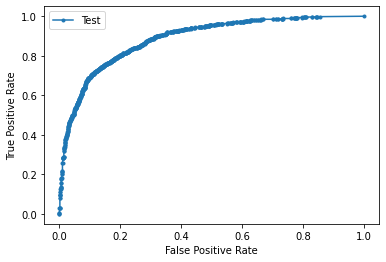

0.8864139073408983


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve
from matplotlib import pyplot


val_proba = clf.predictions_proba
fpr, tpr, thlds = roc_curve(val_labels, val_proba)

pyplot.plot(fpr, tpr, marker='.', label='Test')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()
print(roc_auc_score(val_labels, val_proba))

In [ ]:
optimal_idx = np.argmax(tpr - fpr)
print(optimal_idx)
thld = thlds[optimal_idx]
print(thld)


y_pred_val = (val_proba > thld).float()
acc = Accuracy()
acc(y_pred_val, torch.tensor(val_labels))

352
0.56476504


tensor(0.8036)

In [ ]:
trainer.test(clf, test_loader)

test_proba = clf.predictions_proba
y_pred_test = (test_proba > thld).float()


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


In [ ]:
!mkdir data/output

In [ ]:
def generate_output(predictions, path):
    result = [{"id" : id, "tag": "T"} if pred else {"id" : id, "tag": "F"} for id, pred in zip(df_test["id"].tolist(), predictions)]
    with open(path, 'w') as f:
        df = f.write(json.dumps(result))

generate_output(y_pred_test, 'data/output/test.en-en.larger_test')

In [ ]:
!cat 'data/output/test.en-en.larger_test' && cp -r 'data/output/test.en-en.larger_test' '/content/gdrive/My Drive/'

[{"id": "test.en-en.0", "tag": "F"}, {"id": "test.en-en.1", "tag": "F"}, {"id": "test.en-en.2", "tag": "T"}, {"id": "test.en-en.3", "tag": "T"}, {"id": "test.en-en.4", "tag": "T"}, {"id": "test.en-en.5", "tag": "T"}, {"id": "test.en-en.6", "tag": "T"}, {"id": "test.en-en.7", "tag": "T"}, {"id": "test.en-en.8", "tag": "T"}, {"id": "test.en-en.9", "tag": "T"}, {"id": "test.en-en.10", "tag": "F"}, {"id": "test.en-en.11", "tag": "F"}, {"id": "test.en-en.12", "tag": "T"}, {"id": "test.en-en.13", "tag": "T"}, {"id": "test.en-en.14", "tag": "T"}, {"id": "test.en-en.15", "tag": "T"}, {"id": "test.en-en.16", "tag": "T"}, {"id": "test.en-en.17", "tag": "T"}, {"id": "test.en-en.18", "tag": "F"}, {"id": "test.en-en.19", "tag": "F"}, {"id": "test.en-en.20", "tag": "F"}, {"id": "test.en-en.21", "tag": "F"}, {"id": "test.en-en.22", "tag": "T"}, {"id": "test.en-en.23", "tag": "T"}, {"id": "test.en-en.24", "tag": "F"}, {"id": "test.en-en.25", "tag": "F"}, {"id": "test.en-en.26", "tag": "T"}, {"id": "te